In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt

In [2]:
# Load pretrained model and intermediate layer
model = InceptionV3(weights='imagenet')
layer_name = 'mixed10'
intermediate_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [4]:
# Load and preprocess a target image (e.g., zebra)
img_path = '/zebra.jpg'  # Put your own target image here
img = load_img(img_path, target_size=(299, 299))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
print("Prediction:", decode_predictions(preds, top=3)[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Prediction: [('n02391049', 'zebra', np.float32(0.93795544)), ('n02422106', 'hartebeest', np.float32(0.001263666)), ('n01518878', 'ostrich', np.float32(0.0008051919))]


In [5]:
# Helper function to load images from a folder
def load_images_from_paths(image_paths, target_size=(299, 299)):
    images = []
    for path in image_paths:
        img = load_img(path, target_size=target_size)
        img_array = preprocess_input(np.expand_dims(img_to_array(img), axis=0))
        images.append(img_array)
    return np.vstack(images)

In [7]:
# Load concept and random images from folders
concept_image_paths = [
    '/r1.png',
    '/r2.png',
    '/r3.jpg',
]

random_image_paths = [
    '/s1.jpg',
    '/s2.jpg',
    '/s3.jpg',
]

concept_images = load_images_from_paths(concept_image_paths)
random_images = load_images_from_paths(random_image_paths)


In [8]:
# Extract activations
concept_activations = intermediate_model.predict(concept_images)
random_activations = intermediate_model.predict(random_images)
image_activations = intermediate_model.predict(x)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [9]:
# Train CAV
X = np.concatenate([concept_activations, random_activations])
y = np.array([1] * len(concept_activations) + [0] * len(random_activations))

X_flat = X.reshape(X.shape[0], -1)
clf = SGDClassifier().fit(X_flat, y)
cav = clf.coef_.reshape(concept_activations.shape[1:])

In [10]:
# Compute directional derivative
image_activ_flat = image_activations.reshape(-1)
cav_flat = cav.reshape(-1)
directional_derivative = np.dot(image_activ_flat, cav_flat)
print(f"Directional derivative: {directional_derivative:.4f}")


Directional derivative: -6683.4365


In [11]:
# TCAV Score
tcav_score = np.mean([np.dot(act.reshape(-1), cav_flat) > 0 for act in concept_activations])
print(f"TCAV Score for concept: {tcav_score:.2f}")

TCAV Score for concept: 1.00


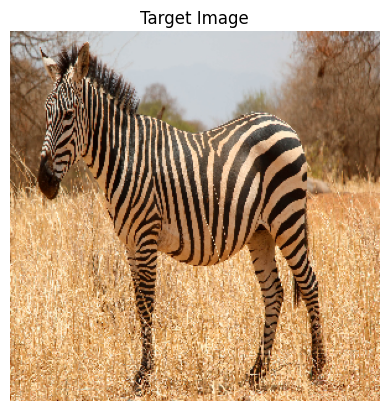

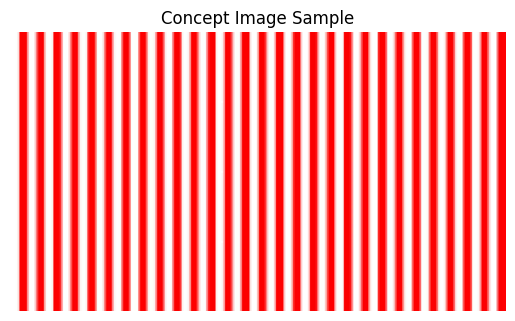

In [12]:
# Visualization
plt.imshow(img)
plt.title("Target Image")
plt.axis('off')
plt.show()

concept_folder = '.'
plt.imshow(load_img(concept_image_paths[0]))
plt.title("Concept Image Sample")
plt.axis('off')
plt.show()
